### Libs

In [1]:
from torchvision.datasets import CelebA
import os
import torch.nn as nn
import glob
import os
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
import torch
import math
# main libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.nn import functional as F
from torch import nn
from torch import optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset
import math
import torchvision.transforms.functional as TF
import cv2
from keras.utils import image_dataset_from_directory
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.nn.parameter import Parameter

from torch.nn import init
from torchvision.utils import make_grid
from collections import OrderedDict

import torch
from torch.utils.data import Dataset

from skimage import transform
import skimage.io as io
import numpy as np
from torchvision.utils import save_image

### Helper Functions

In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 32, 32)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [4]:
def ploter(image, image_hat):
    """
    (H, W)
    """
    plt.figure()
    plt.subplot(1,2,1)
    #plt.imshow(image_hat, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(image_hat)
    plt.tight_layout()
    plt.title("Reconstruct")

    plt.subplot(1,2,2)
    #plt.imshow(image, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(image)
    plt.tight_layout()
    plt.title("Original")

    plt.show()

### Nets

In [5]:
class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x

In [6]:
class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

In [7]:
class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi

In [8]:
class AttU_Net(nn.Module):
    def __init__(self,img_ch=1,output_ch=1, features=2):
        super(AttU_Net,self).__init__()

        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=features*1)
        self.Conv2 = conv_block(ch_in=features*1,ch_out=features*2)
        self.Conv3 = conv_block(ch_in=features*2,ch_out=features*4)
        self.Conv4 = conv_block(ch_in=features*4,ch_out=features*8)
        self.Conv5 = conv_block(ch_in=features*8,ch_out=features*16)

        self.Up5 = up_conv(ch_in=features*16,ch_out=features*8)
        self.Att5 = Attention_block(F_g=features*8,F_l=features*8,F_int=features*4)
        self.Up_conv5 = conv_block(ch_in=features*16, ch_out=features*8)

        self.Up4 = up_conv(ch_in=features*8,ch_out=features*4)
        self.Att4 = Attention_block(F_g=features*4,F_l=features*4,F_int=features*2)
        self.Up_conv4 = conv_block(ch_in=features*8, ch_out=features*4)

        self.Up3 = up_conv(ch_in=features*4,ch_out=features*2)
        self.Att3 = Attention_block(F_g=features*2,F_l=features*2,F_int=features*1)
        self.Up_conv3 = conv_block(ch_in=features*4, ch_out=features*2)

        self.Up2 = up_conv(ch_in=features*2,ch_out=features*1)
        self.Att2 = Attention_block(F_g=features*1,F_l=features*1,F_int=int(features/2))
        self.Up_conv2 = conv_block(ch_in=features*2, ch_out=features*1)

        self.Conv_1x1 = nn.Conv2d(features*1,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)

        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1


In [9]:
m = AttU_Net(1,1,8)
m(torch.ones(10,1,32,32)).shape
count_parameters(m)

547657

In [10]:
class Generator(nn.Module):
    def __init__(self, img_size, latent_dim, channels):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        self.linear_layer = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_layers = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.linear_layer(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        image = self.conv_layers(out)
        return image


class Discriminator(nn.Module):
    def __init__(self, channels, img_size):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_layers = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # self.ds_size = img_size // 2 ** 4 # for img_size = 96
        self.ds_size = 2 # for img_size = 28
        self.adverse_layer = nn.Sequential(nn.Linear(128 * self.ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, image):
        out = self.conv_layers(image)
        out = out.view(out.shape[0], -1)
        validity = self.adverse_layer(out)
        return validity

In [11]:
class DResidualBlock(nn.Module):
    '''
    DResidualBlock Class
    Values:
    in_channels: the number of channels in the input, a scalar
    out_channels: the number of channels in the output, a scalar
    downsample: whether to apply downsampling
    use_preactivation: whether to apply an activation function before the first convolution
    '''

    def __init__(self, in_channels, out_channels, downsample=True, use_preactivation=False):
        super().__init__()

        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))

        self.activation = nn.ReLU()
        self.use_preactivation = use_preactivation  # apply preactivation in all except first dblock

        self.downsample = downsample    # downsample occurs in all except last dblock
        if downsample:
            self.downsample_fn = nn.AvgPool2d(2)
        self.mixin = (in_channels != out_channels) or downsample
        if self.mixin:
            self.conv_mixin = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0))

    def _residual(self, x):
        if self.use_preactivation:
            if self.mixin:
                x = self.conv_mixin(x)
            if self.downsample:
                x = self.downsample_fn(x)
        else:
            if self.downsample:
                x = self.downsample_fn(x)
            if self.mixin:
                x = self.conv_mixin(x)
        return x

    def forward(self, x):
        # Apply preactivation if applicable
        if self.use_preactivation:
            h = F.relu(x)
        else:
            h = x

        h = self.conv1(h)
        h = self.activation(h)
        if self.downsample:
            h = self.downsample_fn(h)

        return h + self._residual(x)

In [12]:
class AttentionBlock(nn.Module):
    '''
    AttentionBlock Class
    Values:
    channels: number of channels in input
    '''
    def __init__(self, channels):
        super().__init__()

        self.channels = channels

        self.theta = nn.utils.spectral_norm(nn.Conv2d(channels, channels // 8, kernel_size=1, padding=0, bias=False))
        self.phi = nn.utils.spectral_norm(nn.Conv2d(channels, channels // 8, kernel_size=1, padding=0, bias=False))
        self.g = nn.utils.spectral_norm(nn.Conv2d(channels, channels // 2, kernel_size=1, padding=0, bias=False))
        self.o = nn.utils.spectral_norm(nn.Conv2d(channels // 2, channels, kernel_size=1, padding=0, bias=False))

        self.gamma = nn.Parameter(torch.tensor(0.), requires_grad=True)

    def forward(self, x):
        spatial_size = x.shape[2] * x.shape[3]

        # Apply convolutions to get query (theta), key (phi), and value (g) transforms
        theta = self.theta(x)
        phi = F.max_pool2d(self.phi(x), kernel_size=2)
        g = F.max_pool2d(self.g(x), kernel_size=2)

        # Reshape spatial size for self-attention
        theta = theta.view(-1, self.channels // 8, spatial_size)
        phi = phi.view(-1, self.channels // 8, spatial_size // 4)
        g = g.view(-1, self.channels // 2, spatial_size // 4)

        # Compute dot product attention with query (theta) and key (phi) matrices
        beta = F.softmax(torch.bmm(theta.transpose(1, 2), phi), dim=-1)

        # Compute scaled dot product attention with value (g) and attention (beta) matrices
        o = self.o(torch.bmm(g, beta.transpose(1, 2)).view(-1, self.channels // 2, x.shape[2], x.shape[3]))

        # Apply gain and residual
        return self.gamma * o + x

In [13]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
    base_channels: the number of base channels, a scalar
    n_classes: the number of image classes, a scalar
    '''

    def __init__(self, base_channels=96, n_classes=1000):
        super().__init__()

        # For adding class-conditional evidence
        self.shared_emb = nn.utils.spectral_norm(nn.Embedding(n_classes, 8 * base_channels))

        self.d_blocks = nn.Sequential(
            DResidualBlock(1, base_channels, downsample=True, use_preactivation=False),
            AttentionBlock(base_channels),

            DResidualBlock(base_channels, 2 * base_channels, downsample=True, use_preactivation=True),
            AttentionBlock(2 * base_channels),

            DResidualBlock(2 * base_channels, 4 * base_channels, downsample=True, use_preactivation=True),
            AttentionBlock(4 * base_channels),

            DResidualBlock(4 * base_channels, 8 * base_channels, downsample=True, use_preactivation=True),
            AttentionBlock(8 * base_channels),
            nn.ReLU(inplace=True),
        )
        self.proj_o = nn.utils.spectral_norm(nn.Linear(8 * base_channels, 1))
        self.sigmo = nn.Sigmoid()

    def forward(self, x, y=None):
        h = self.d_blocks(x)
        h = torch.sum(h, dim=[2, 3])

        # Class-unconditional output
        uncond_out = self.proj_o(h)
        if y is None:
            return F.sigmoid(uncond_out)

        # Class-conditional output
        cond_out = torch.sum(self.shared_emb(y) * h, dim=1, keepdim=True)
        out = uncond_out + cond_out
        return F.sigmoid(out)

In [14]:
# TEST
G = Generator(28, 100, 1)
x = torch.ones(1, 1, 28, 28).to(torch.float)
z = torch.FloatTensor(np.random.normal(0, 1, (x.shape[0], 100)))
G(z).shape
count_parameters(G)

856065

In [15]:
# TEST
D = Discriminator(1, 28)
x = torch.ones(1, 1, 28, 28).to(torch.float)
D(x).shape

/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


RuntimeError: ignored

In [16]:
os.environ['TORCH_HOME'] = './pretrain_models'
VGG = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to ./pretrain_models/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to ./pretrain_models/hub/checkpoints/vgg11-8a719046.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

### Hyperparameters

In [25]:
root_save = "./best_models"
root_ds = "./MNIST"

device = 'cuda'

batch_size = 64
img_size = 32
latent_dim = 100
channels = 1
num_epochs = 1000
sample_interval = 1

### Dataset

In [18]:
trans=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(img_size),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((0.5,) , (0.5,))
])

train_data=datasets.MNIST(root=root_ds,
                          train=True, transform=trans, download=True)
test_data=datasets.MNIST(root=root_ds,
                          train=False, transform=trans, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



In [19]:
def get_index(class_num, dataset, mode:str):
    if mode == 'train':
        class_indx = torch.nonzero(
                dataset.train_labels == class_num * torch.ones_like(dataset.train_labels)
        )

    if mode == 'test':
        class_indx = torch.nonzero(
                dataset.test_labels == class_num * torch.ones_like(dataset.test_labels)
        )

    class_indx = class_indx.squeeze(1)
    return class_indx

In [26]:
train_sampler = SubsetRandomSampler(get_index(8, train_data, 'train'))
test_sampler = SubsetRandomSampler(get_index(8, test_data, 'test'))

train_loader=DataLoader(train_data, batch_size= batch_size, sampler=train_sampler)
test_loader=DataLoader(test_data, batch_size= len(test_sampler), sampler=test_sampler)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


### Loss

In [28]:
#generator = Generator(img_size=img_size, latent_dim=latent_dim, channels=channels).cuda()
generator = AttU_Net(1,1,8).to(device)
#discriminator = Discriminator(channels=channels, img_size=img_size).cuda()
discriminator = Discriminator(8,1).to(device)
VGG = VGG.to(device)

In [29]:
adversarial_loss = nn.BCELoss()
feature_loss = nn.MSELoss()
optimizer_G = optim.Adam(generator.parameters())
optimizer_D = optim.Adam(discriminator.parameters())

In [30]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [31]:
generator = generator.apply(weights_init_normal)
discriminator = discriminator.apply(weights_init_normal)

### Train

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


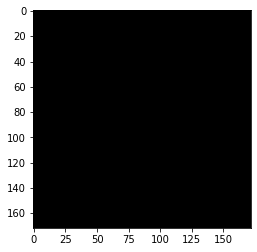

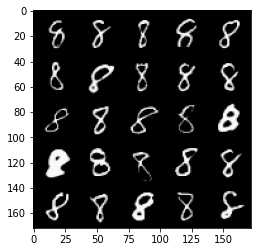

[Epoch 1/1000] 	[D loss: 10.577] 	[G loss: 327.488]


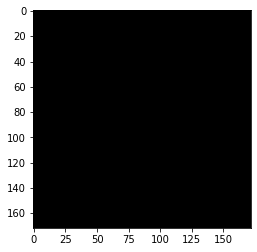

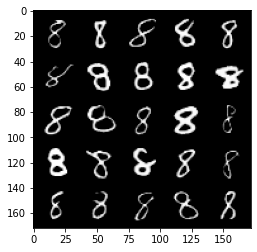

[Epoch 2/1000] 	[D loss: 4.474] 	[G loss: 348.460]


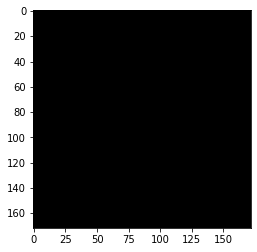

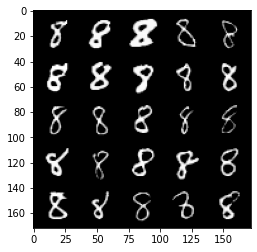

[Epoch 3/1000] 	[D loss: 2.270] 	[G loss: 449.517]


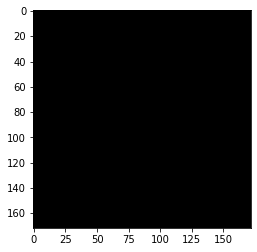

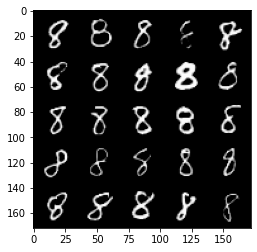

[Epoch 4/1000] 	[D loss: 0.787] 	[G loss: 477.358]


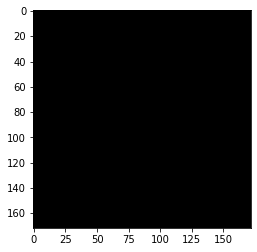

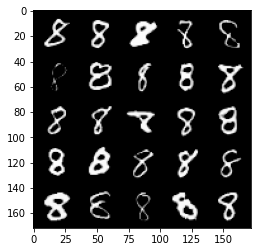

[Epoch 5/1000] 	[D loss: 1.149] 	[G loss: 509.416]


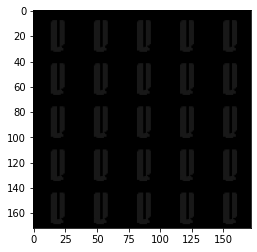

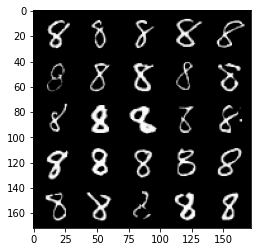

[Epoch 6/1000] 	[D loss: 2.633] 	[G loss: 517.319]


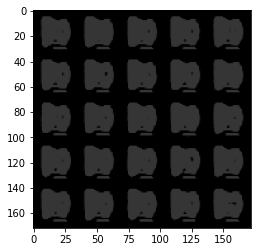

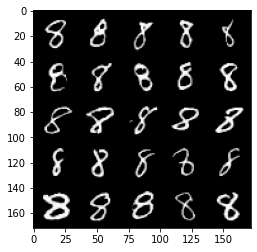

[Epoch 7/1000] 	[D loss: 8.393] 	[G loss: 420.346]


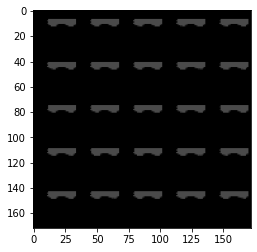

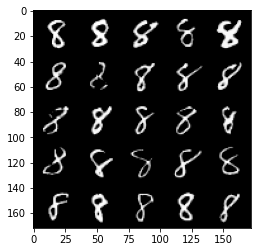

[Epoch 8/1000] 	[D loss: 4.262] 	[G loss: 347.354]


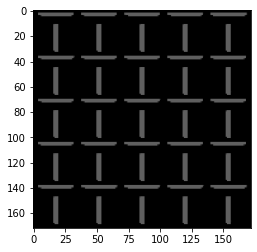

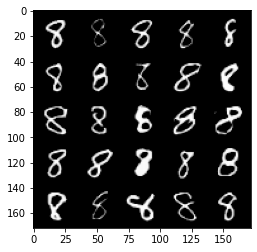

[Epoch 9/1000] 	[D loss: 16.012] 	[G loss: 297.231]


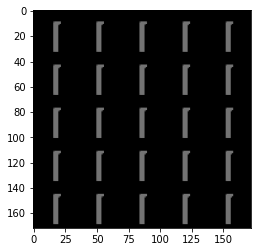

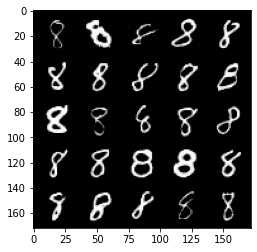

[Epoch 10/1000] 	[D loss: 12.340] 	[G loss: 265.672]


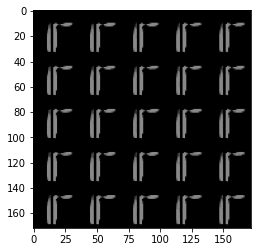

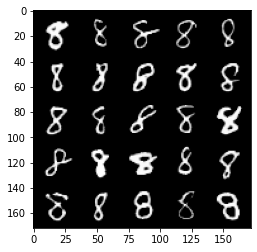

[Epoch 11/1000] 	[D loss: 17.236] 	[G loss: 294.483]


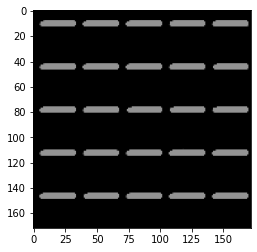

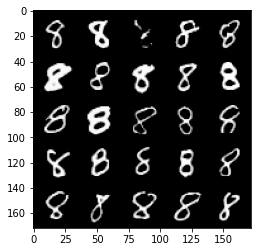

[Epoch 12/1000] 	[D loss: 19.022] 	[G loss: 238.012]


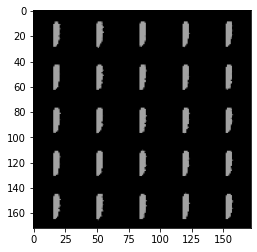

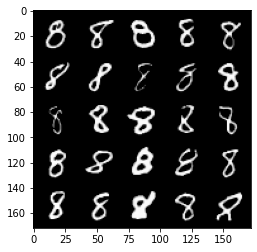

[Epoch 13/1000] 	[D loss: 21.037] 	[G loss: 241.630]


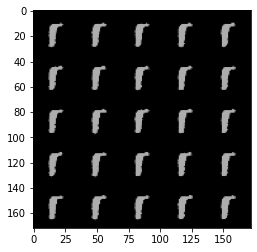

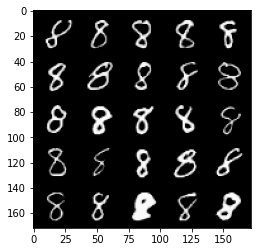

[Epoch 14/1000] 	[D loss: 22.997] 	[G loss: 232.456]


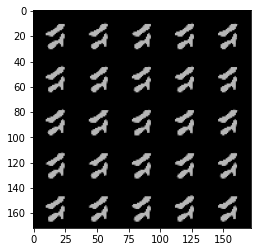

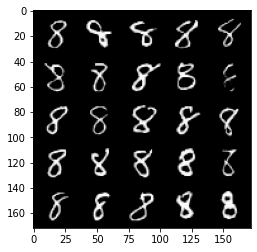

[Epoch 15/1000] 	[D loss: 57.668] 	[G loss: 92.297]


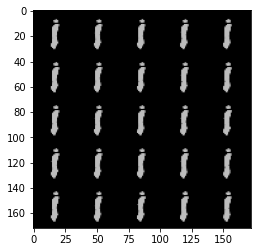

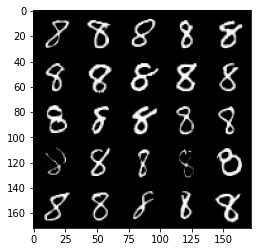

[Epoch 16/1000] 	[D loss: 46.924] 	[G loss: 98.312]


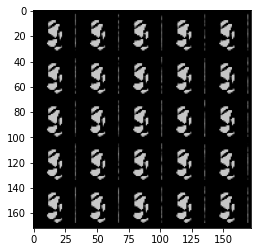

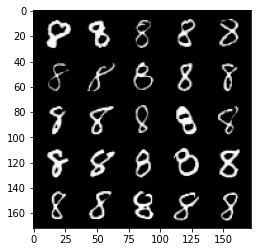

[Epoch 17/1000] 	[D loss: 26.599] 	[G loss: 163.807]


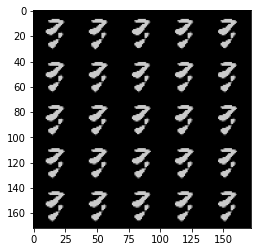

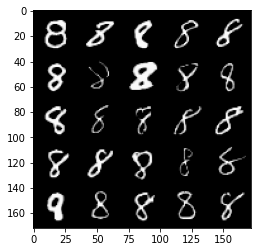

[Epoch 18/1000] 	[D loss: 62.211] 	[G loss: 85.390]


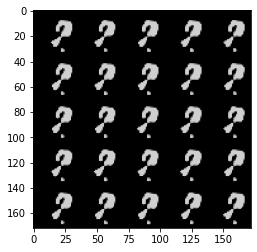

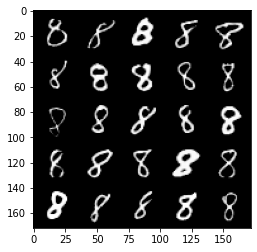

[Epoch 19/1000] 	[D loss: 51.350] 	[G loss: 90.193]


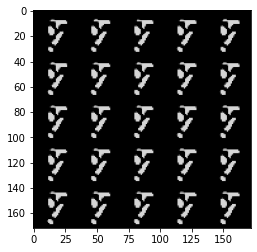

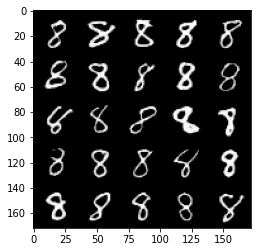

[Epoch 20/1000] 	[D loss: 47.255] 	[G loss: 115.958]


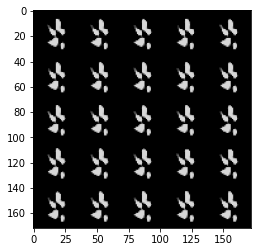

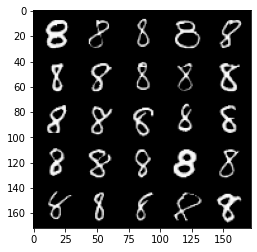

[Epoch 21/1000] 	[D loss: 51.549] 	[G loss: 88.206]


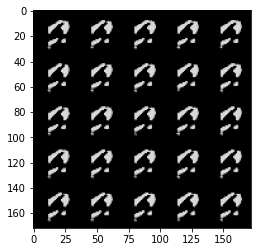

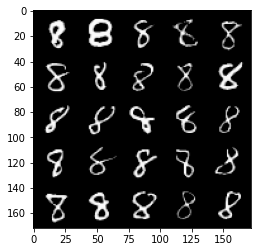

[Epoch 22/1000] 	[D loss: 34.196] 	[G loss: 133.759]


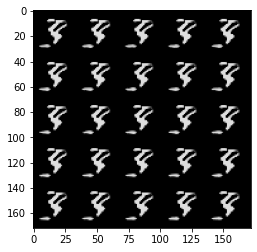

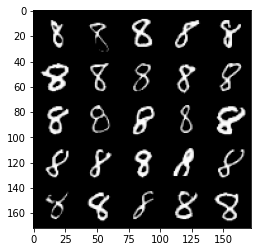

[Epoch 23/1000] 	[D loss: 51.229] 	[G loss: 109.732]


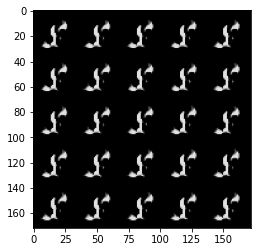

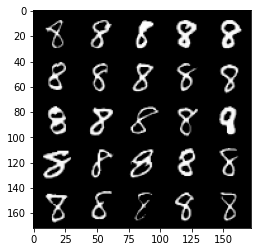

[Epoch 24/1000] 	[D loss: 44.085] 	[G loss: 101.788]


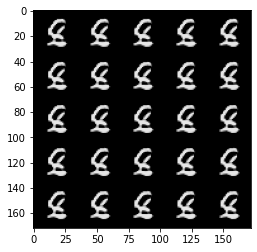

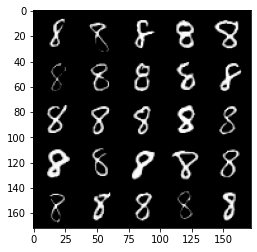

[Epoch 25/1000] 	[D loss: 48.591] 	[G loss: 108.990]


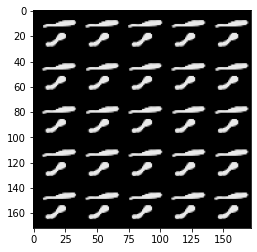

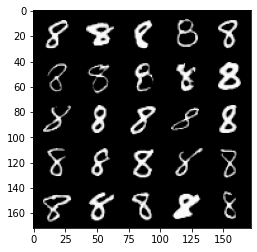

[Epoch 26/1000] 	[D loss: 45.433] 	[G loss: 113.609]


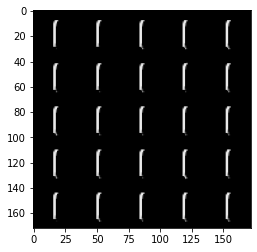

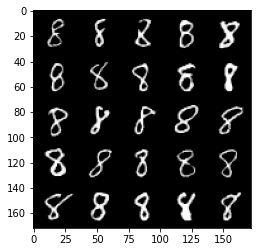

[Epoch 27/1000] 	[D loss: 33.230] 	[G loss: 168.699]


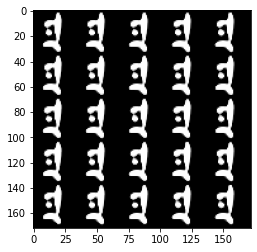

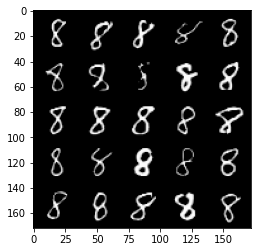

[Epoch 28/1000] 	[D loss: 11.528] 	[G loss: 239.602]


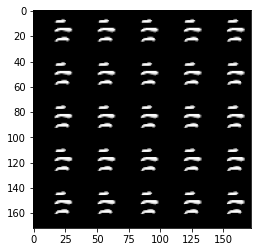

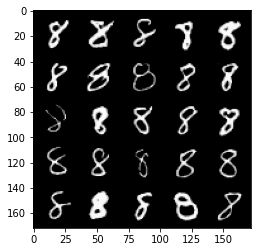

[Epoch 29/1000] 	[D loss: 42.899] 	[G loss: 144.944]


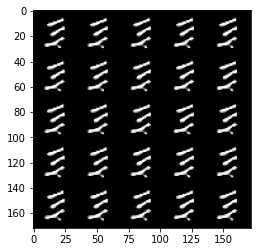

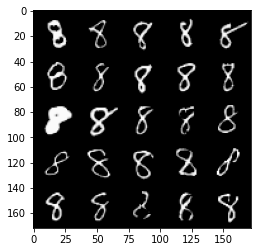

[Epoch 30/1000] 	[D loss: 33.874] 	[G loss: 152.152]


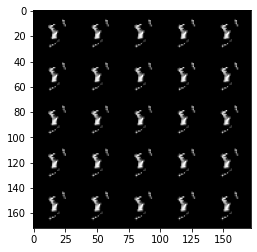

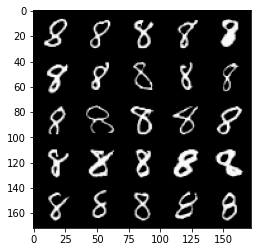

[Epoch 31/1000] 	[D loss: 55.283] 	[G loss: 106.289]


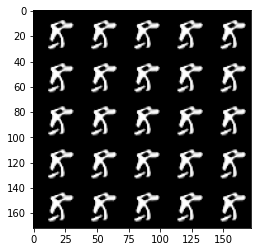

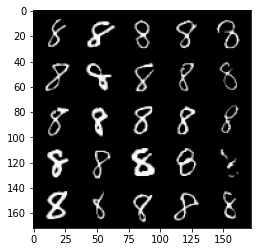

[Epoch 32/1000] 	[D loss: 61.433] 	[G loss: 77.672]


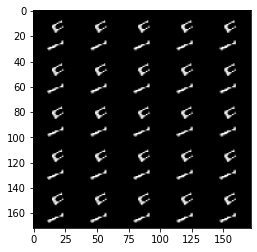

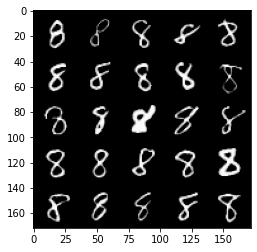

[Epoch 33/1000] 	[D loss: 68.701] 	[G loss: 71.956]


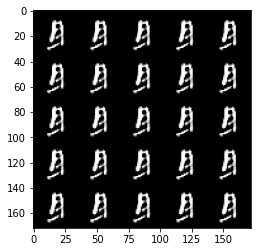

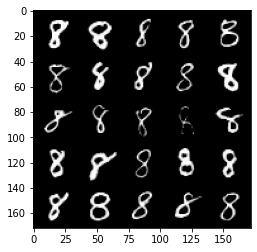

[Epoch 34/1000] 	[D loss: 60.829] 	[G loss: 73.052]


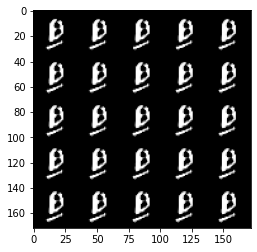

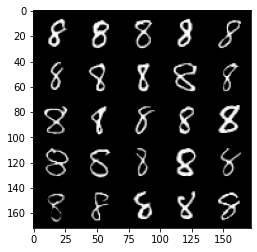

[Epoch 35/1000] 	[D loss: 63.076] 	[G loss: 67.912]


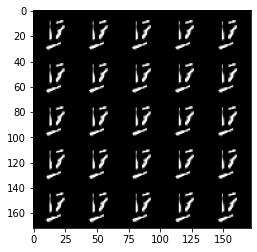

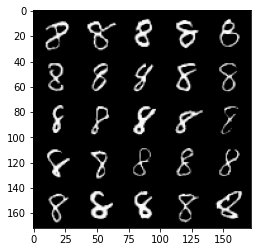

[Epoch 36/1000] 	[D loss: 61.696] 	[G loss: 70.793]


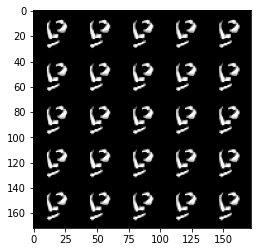

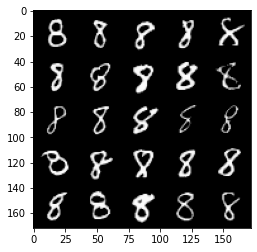

[Epoch 37/1000] 	[D loss: 62.736] 	[G loss: 69.865]


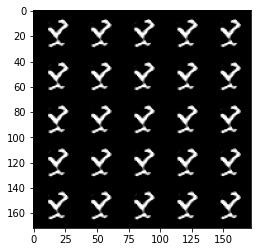

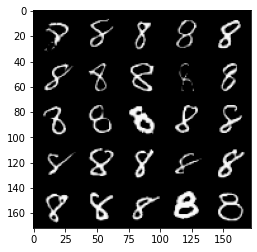

[Epoch 38/1000] 	[D loss: 61.897] 	[G loss: 69.975]


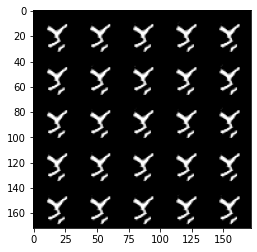

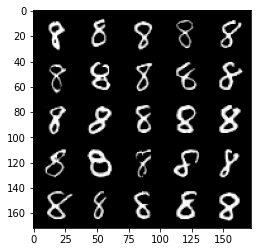

[Epoch 39/1000] 	[D loss: 62.444] 	[G loss: 69.612]


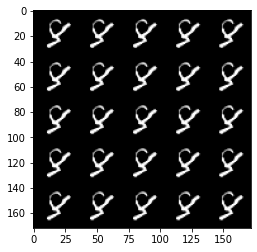

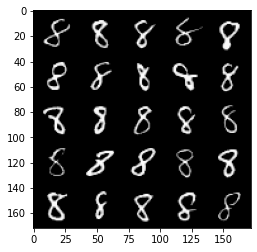

[Epoch 40/1000] 	[D loss: 54.841] 	[G loss: 78.671]


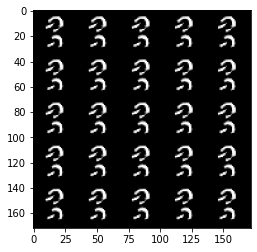

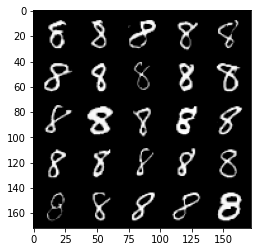

[Epoch 41/1000] 	[D loss: 55.240] 	[G loss: 91.075]


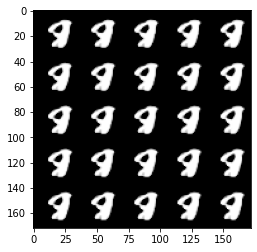

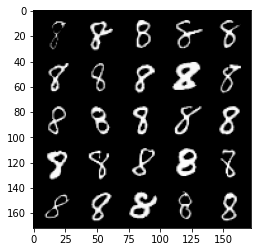

[Epoch 42/1000] 	[D loss: 57.781] 	[G loss: 94.392]


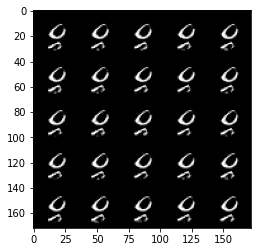

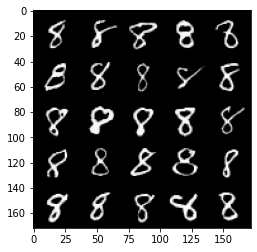

[Epoch 43/1000] 	[D loss: 52.490] 	[G loss: 95.943]


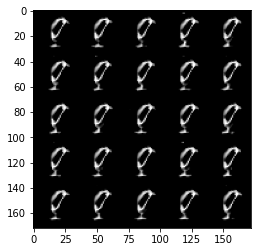

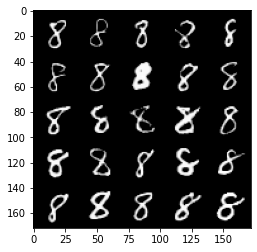

[Epoch 44/1000] 	[D loss: 57.627] 	[G loss: 81.783]


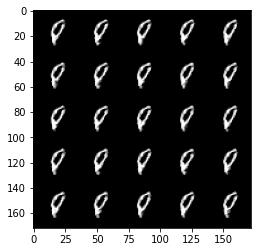

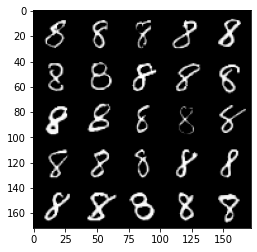

[Epoch 45/1000] 	[D loss: 50.760] 	[G loss: 93.378]


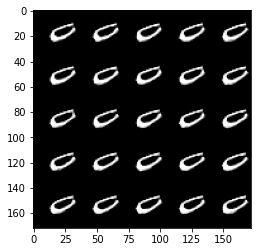

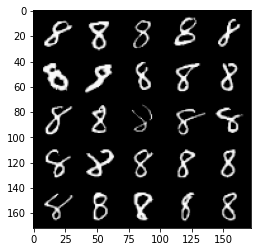

[Epoch 46/1000] 	[D loss: 51.052] 	[G loss: 92.219]


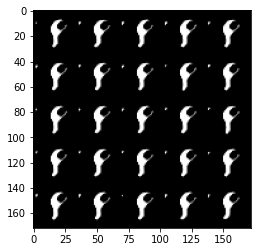

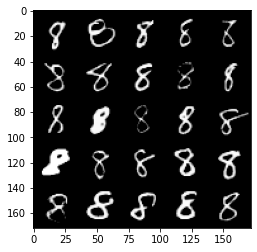

[Epoch 47/1000] 	[D loss: 35.999] 	[G loss: 145.217]


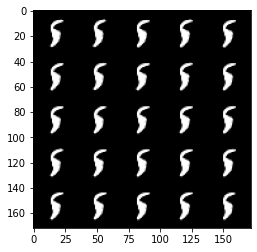

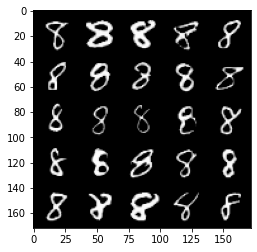

[Epoch 48/1000] 	[D loss: 59.030] 	[G loss: 100.316]


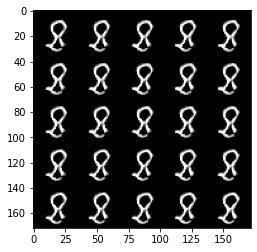

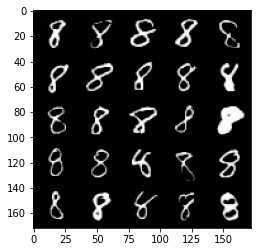

[Epoch 49/1000] 	[D loss: 64.899] 	[G loss: 71.516]


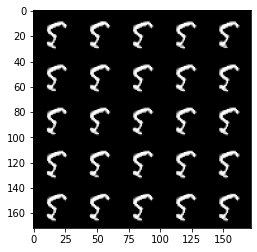

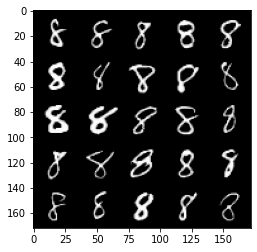

[Epoch 50/1000] 	[D loss: 64.423] 	[G loss: 71.431]


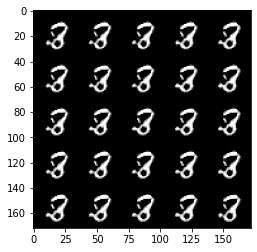

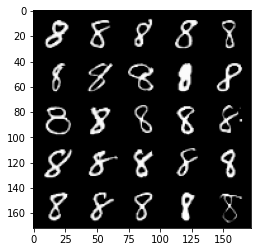

[Epoch 51/1000] 	[D loss: 65.027] 	[G loss: 67.044]


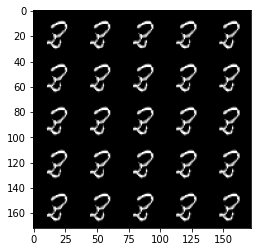

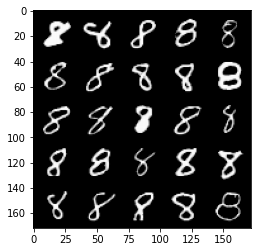

[Epoch 52/1000] 	[D loss: 59.385] 	[G loss: 74.228]


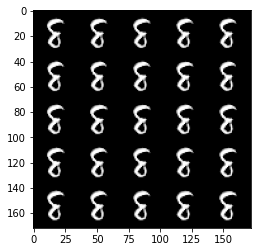

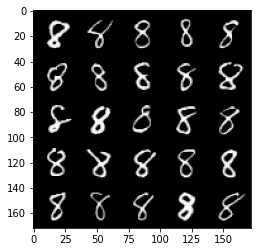

[Epoch 53/1000] 	[D loss: 67.870] 	[G loss: 64.093]


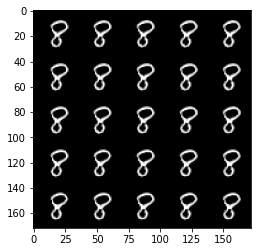

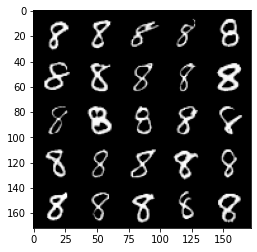

[Epoch 54/1000] 	[D loss: 61.338] 	[G loss: 71.441]


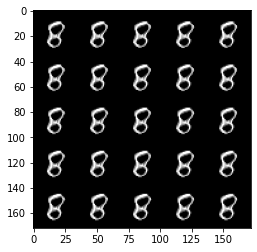

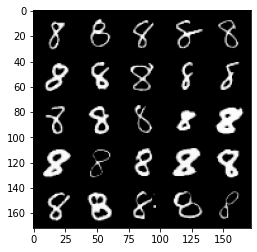

[Epoch 55/1000] 	[D loss: 60.472] 	[G loss: 71.528]


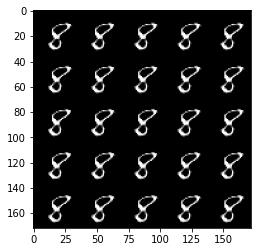

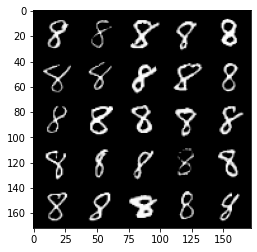

[Epoch 56/1000] 	[D loss: 59.981] 	[G loss: 73.984]


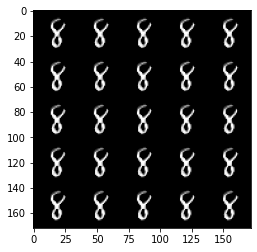

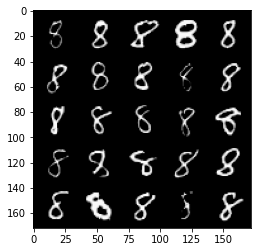

[Epoch 57/1000] 	[D loss: 63.624] 	[G loss: 74.585]


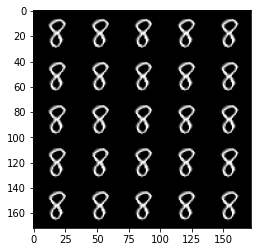

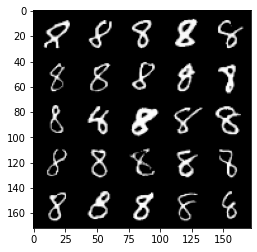

[Epoch 58/1000] 	[D loss: 57.937] 	[G loss: 74.993]


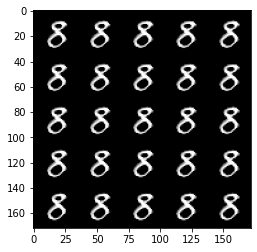

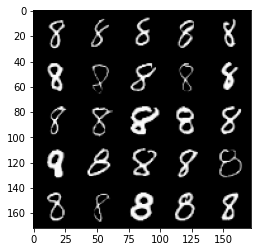

[Epoch 59/1000] 	[D loss: 59.074] 	[G loss: 73.952]


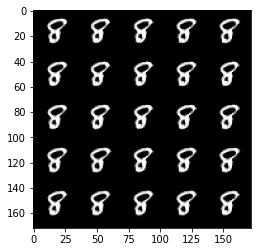

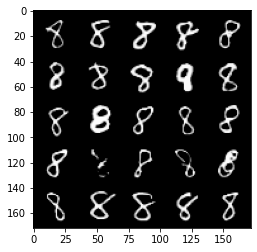

[Epoch 60/1000] 	[D loss: 53.313] 	[G loss: 83.655]


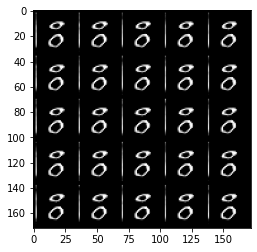

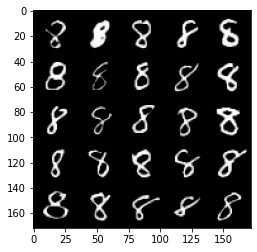

[Epoch 61/1000] 	[D loss: 60.290] 	[G loss: 75.474]


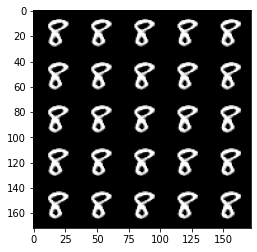

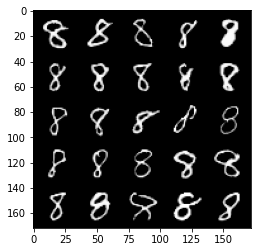

[Epoch 62/1000] 	[D loss: 58.793] 	[G loss: 78.340]


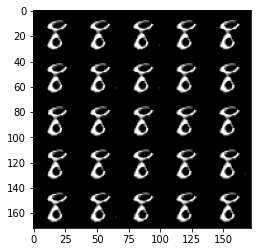

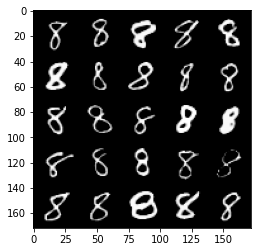

[Epoch 63/1000] 	[D loss: 56.171] 	[G loss: 84.289]


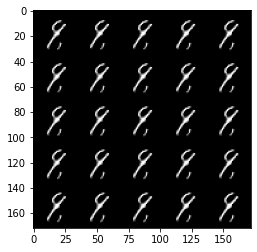

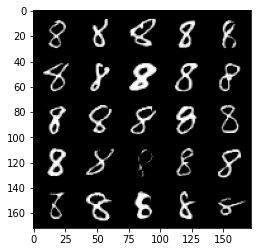

[Epoch 64/1000] 	[D loss: 59.198] 	[G loss: 79.080]


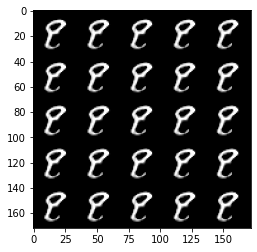

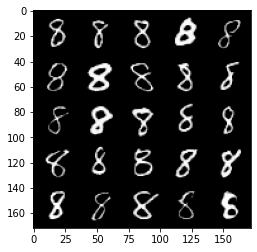

[Epoch 65/1000] 	[D loss: 62.244] 	[G loss: 72.577]


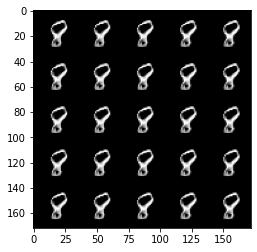

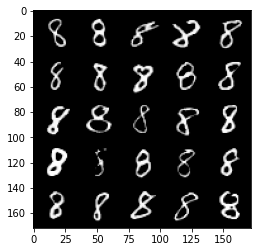

[Epoch 66/1000] 	[D loss: 50.785] 	[G loss: 86.648]


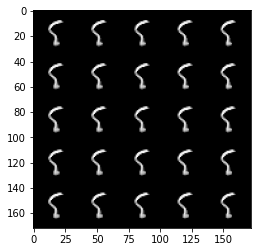

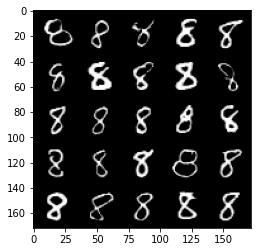

[Epoch 67/1000] 	[D loss: 67.171] 	[G loss: 73.403]


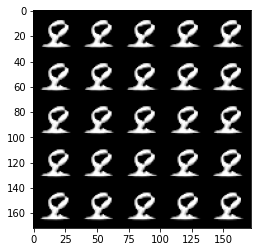

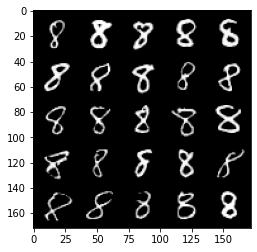

[Epoch 68/1000] 	[D loss: 60.996] 	[G loss: 75.410]


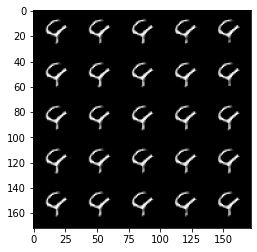

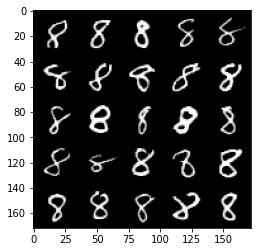

[Epoch 69/1000] 	[D loss: 62.233] 	[G loss: 73.441]


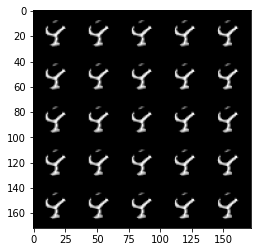

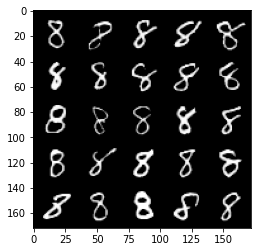

[Epoch 70/1000] 	[D loss: 61.003] 	[G loss: 72.378]


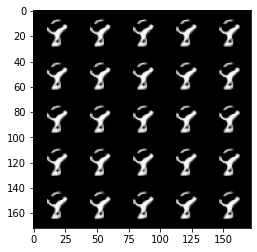

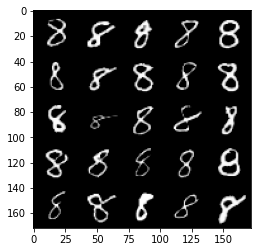

[Epoch 71/1000] 	[D loss: 55.807] 	[G loss: 77.665]


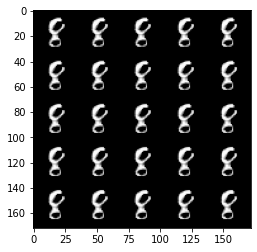

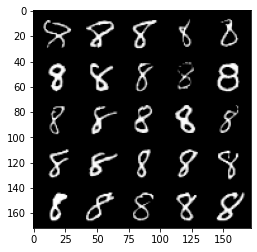

[Epoch 72/1000] 	[D loss: 51.537] 	[G loss: 87.979]


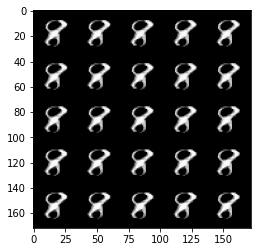

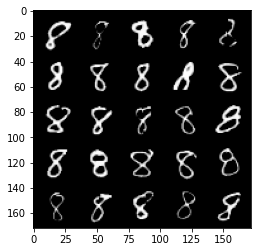

[Epoch 73/1000] 	[D loss: 55.350] 	[G loss: 81.767]


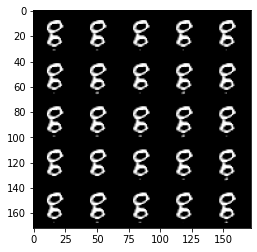

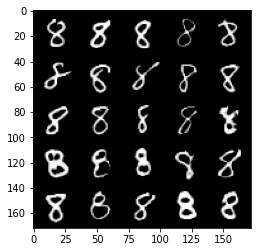

[Epoch 74/1000] 	[D loss: 53.705] 	[G loss: 92.073]


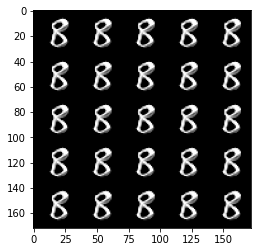

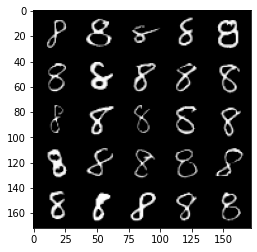

[Epoch 75/1000] 	[D loss: 59.162] 	[G loss: 80.124]


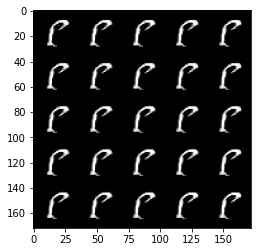

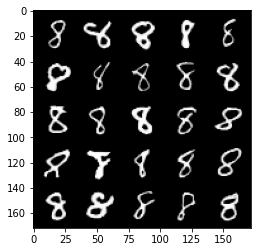

[Epoch 76/1000] 	[D loss: 52.301] 	[G loss: 88.599]


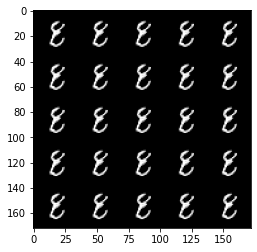

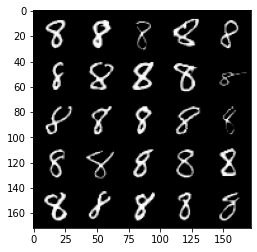

[Epoch 77/1000] 	[D loss: 59.402] 	[G loss: 83.145]


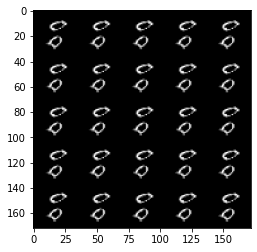

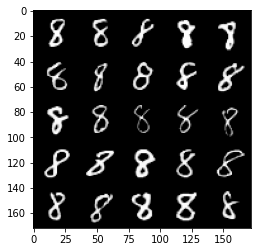

[Epoch 78/1000] 	[D loss: 49.612] 	[G loss: 90.797]


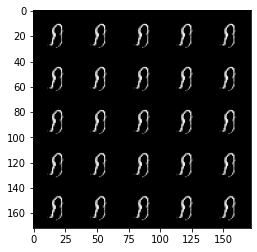

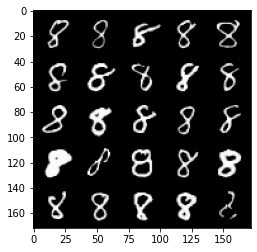

[Epoch 79/1000] 	[D loss: 53.702] 	[G loss: 101.201]


KeyboardInterrupt: ignored

In [32]:
for epoch in range(1, num_epochs):
    total_G_loss = 0.0
    total_D_loss = 0.0
    for i, (real_images, _) in enumerate(train_loader):
        valid = torch.FloatTensor(real_images.shape[0], 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(real_images.shape[0], 1).fill_(0.0).to(device)
        real_images = real_images.to(device)

        #  Train Generator
        optimizer_G.zero_grad()
        #z = torch.FloatTensor(np.random.normal(0, 1, (real_images.shape[0], latent_dim))).cuda()
        z = torch.FloatTensor(np.random.normal(0, 1, (real_images.shape[0], 1, img_size, img_size))).to(device)
        gen_imgs = generator(z)

        gan_loss = adversarial_loss(discriminator(gen_imgs), valid)


        feature1_loss = feature_loss(
            VGG.features[0:2](real_images.repeat(1,3,1,1)),
            VGG.features[0:2](gen_imgs.repeat(1,3,1,1))
        )

        feature2_loss = feature_loss(
            VGG.features[0:5](real_images.repeat(1,3,1,1)),
            VGG.features[0:5](gen_imgs.repeat(1,3,1,1))
        )

        feature3_loss = feature_loss(
            VGG.features[0:8](real_images.repeat(1,3,1,1)),
            VGG.features[0:8](gen_imgs.repeat(1,3,1,1))
        )


        g_loss = gan_loss + 0.01*(feature1_loss + feature2_loss + feature3_loss) + 2e-4*feature_loss(real_images, gen_imgs)
        g_loss.backward()
        optimizer_G.step()
        total_G_loss += g_loss.cpu().detach().numpy()

        #  Train Discriminator
        optimizer_D.zero_grad()
        discriminator_opinion_real = discriminator(real_images)
        discriminator_opinion_fake = discriminator(gen_imgs.detach())
        real_loss = adversarial_loss(discriminator_opinion_real, valid)
        fake_loss = adversarial_loss(discriminator_opinion_fake, fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        total_D_loss += d_loss.cpu().detach().numpy()

    if epoch % sample_interval ==0:

        # show a sample from generator
        #z = torch.FloatTensor(np.random.normal(0, 1, (real_images.shape[0], latent_dim))).cuda()
        for _, (real_images, _) in enumerate(test_loader):

          num = math.floor(
                np.random.uniform(0,len(test_sampler)-100)
            )
          real_images = real_images[num:num+25]

          z = torch.FloatTensor(np.random.normal(0, 1, (real_images.shape[0], 1, img_size, img_size))).to(device)
          gen_imgs = generator(z)
          show_tensor_images(gen_imgs)
          show_tensor_images(real_images)



        # show losses
        print(
                "[Epoch {}/{}] \t[D loss: {:.3f}] \t[G loss: {:.3f}]".format(
                    epoch, num_epochs, total_D_loss, total_G_loss)
            )

        """
        print(
                "[Epoch {}/{}] \t[Feature1 loss: {:.3f}] \t[Feature2 loss: {:.3f}] \t[Feature3 loss: {:.3f}]".format(
                    epoch, num_epochs, feature1_loss.item(), feature2_loss.item(), feature3_loss.item())
            )
        """

        """
        # save all
        torch.save({"epoch": epoch,
            "state_dict_G": generator.state_dict(),
            "state_dict_D": discriminator.state_dict(),
            "optimizer_G": optimizer_G.state_dict(),
            "optimizer_D": optimizer_D.state_dict()
           }, root_save + f"/epoch{epoch}_disloss{total_D_loss}_genloss{total_G_loss}.pt")
        """

In [ ]:
"""
if epoch % sample_interval == 0 and i % (len(dataloader)/5) == 0:
    save_image(gen_imgs.data[0,0],
               "images/{}_{}.png".format(str(epoch).zfill(len(str(num_epochs))),
                                         str(i).zfill(len(str(len(dataloader))))),
               normalize=True)
"""

### End